In [5]:
# Example usage
base_path = '/Users/lvrinn/Documents/Kecerdasan Buatan/Code/Proyek/'
annotations_dir = base_path + 'annotations/'
images_dir = base_path + 'images/'

# Visualisasi Data 1

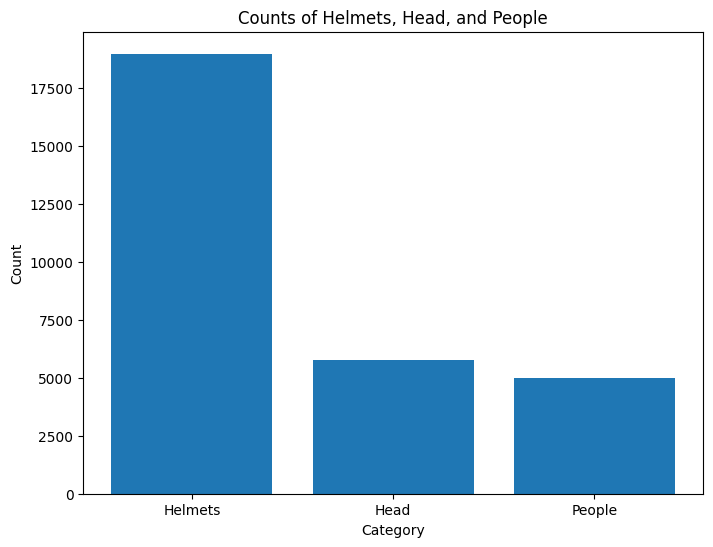

In [2]:
import os
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

# Count the number of helmets, non-helmets, and people
helmet_count = 0
head = 0
person_count = 0

for filename in os.listdir(annotations_dir):
    if filename.endswith('.xml'):
        annotations_path = os.path.join(annotations_dir, filename)
        tree = ET.parse(annotations_path)
        root = tree.getroot()

        image_filename = root.find('filename').text
        image_path = os.path.join(images_dir, image_filename)
        image = cv2.imread(image_path)

        # Count the number of people in the image
        person_count += 1

        for object in root.findall('object'):
            name = object.find('name').text
            if name == 'helmet':
                helmet_count += 1
            elif name == 'head':
                head += 1

# Visualize the counts
labels = ['Helmets', 'Head', 'People']
counts = [helmet_count, head, person_count]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Counts of Helmets, Head, and People')
plt.show()

# Explanation and Conclusion:
# This visualization shows the counts of helmets, non-helmets, and people present in the raw dataset.
# By analyzing this visualization, you can gain insights into the distribution of different categories in the data.
# If there is a significant imbalance between the categories (e.g., many more helmets than non-helmets), it may indicate potential biases or issues in the data collection process.
# This information can help you make informed decisions about potential data augmentation techniques or sampling strategies to balance the dataset during preprocessing or model training.

# Visualisasi Data 2


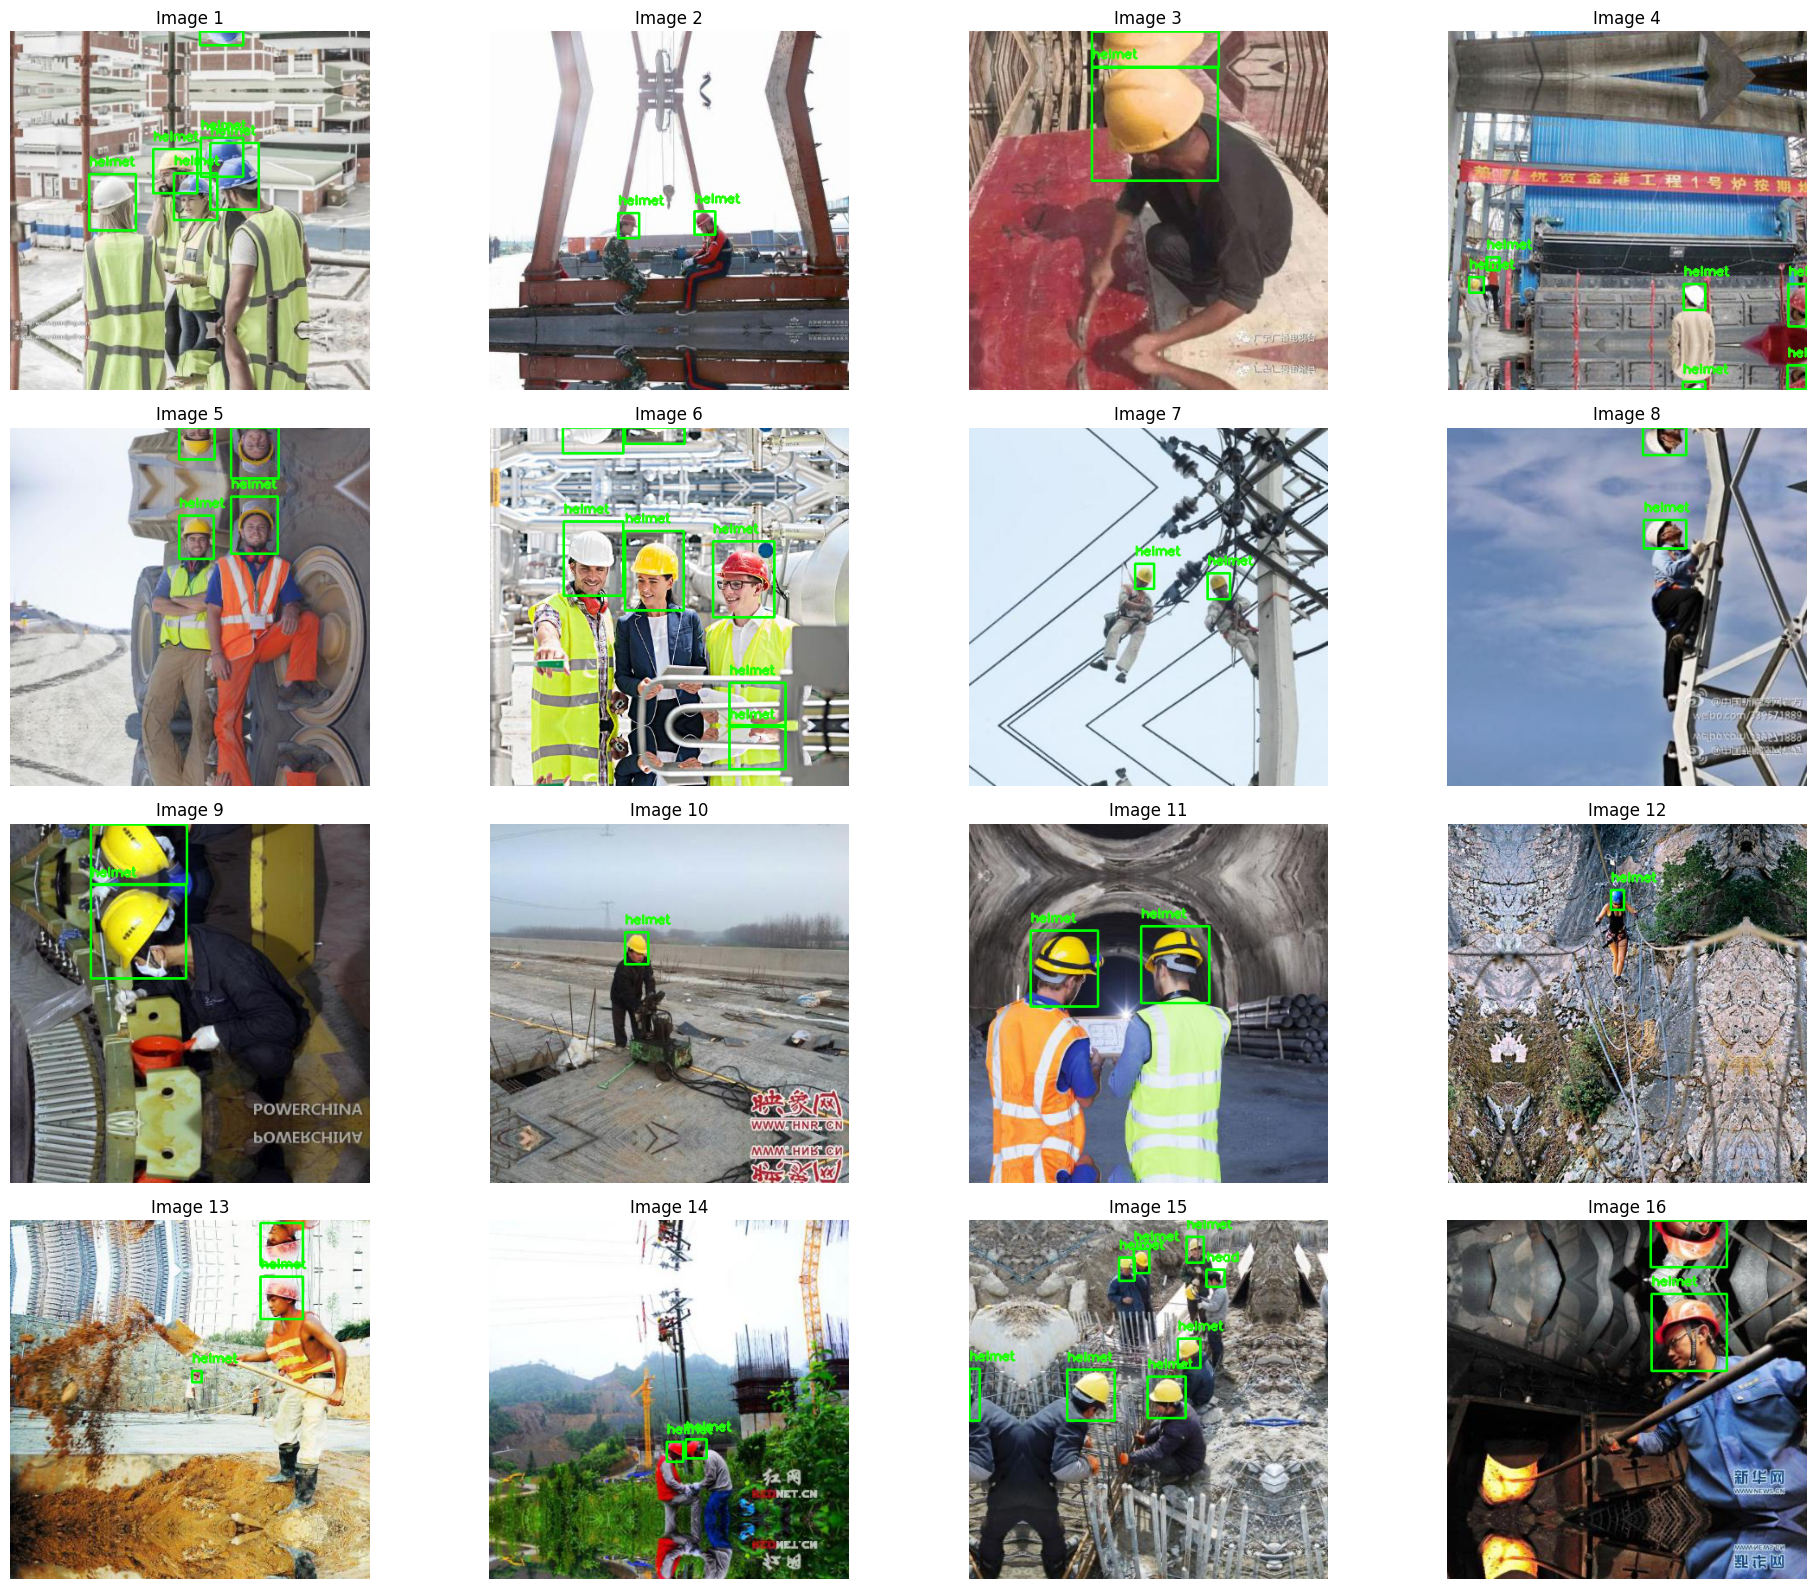

In [3]:
import os
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

# Function to visualize bounding boxes and labels
def visualize_bounding_boxes(image, annotations):
    for bbox in annotations:
        xmin, ymin, xmax, ymax, label = bbox
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36, 255, 12), 2)
    return image

# Load and preprocess images and annotations
images = []
annotations = []

for filename in os.listdir(annotations_dir)[:16]:  # Limit to 16 images
    if filename.endswith('.xml'):
        annotations_path = os.path.join(annotations_dir, filename)
        tree = ET.parse(annotations_path)
        root = tree.getroot()

        image_filename = root.find('filename').text
        image_path = os.path.join(images_dir, image_filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

        image_annotations = []
        for object in root.findall('object'):
            label = object.find('name').text
            bbox = object.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            image_annotations.append([xmin, ymin, xmax, ymax, label])

        images.append(visualize_bounding_boxes(image, image_annotations))
        annotations.append(image_annotations)

# Create a 4x4 grid to display 16 images
fig, axs = plt.subplots(4, 4, figsize=(20, 16))
axs = axs.ravel()  # Flatten the array of axes

for i, (ax, image) in enumerate(zip(axs, images)):
    ax.imshow(image)
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Pre-Processing Data

In [25]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Preprocessing Technique 1: Data Splitting
def split_data(annotations, images):
    # Split data into train and test sets
    train_annotations, test_annotations, train_images, test_images = train_test_split(annotations, images, test_size=0.2, random_state=42)
    return train_annotations, test_annotations, train_images, test_images

# Rationale and Explanation:
# Splitting the data into train and test sets is a crucial preprocessing step for machine learning models. It ensures that the model is trained on a subset of the data and evaluated on a separate, unseen portion of the data. This helps assess the model's ability to generalize to new, unseen data and prevent overfitting.
# The train_test_split function from scikit-learn is a convenient way to perform this split, allowing you to specify the desired test set size and set a random seed for reproducibility.

# Preprocessing Technique 2: Data Augmentation
def augment_data(images, annotations):
    augmented_images = []
    augmented_annotations = []

    for image, annotation in zip(images, annotations):
        # Apply horizontal flip
        flipped_image = cv2.flip(image, 1)
        flipped_annotation = [[image.shape[1] - xmax, ymin, image.shape[1] - xmin, ymax, label] for xmin, ymin, xmax, ymax, label in annotation]

        augmented_images.append(flipped_image)
        augmented_annotations.append(flipped_annotation)

        # Apply rotation (e.g., 90 degrees)
        rows, cols, _ = image.shape
        rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), 90, 1)
        rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
        rotated_annotation = [[ymin, cols - xmax, ymax, cols - xmin, label] for xmin, ymin, xmax, ymax, label in annotation]

        augmented_images.append(rotated_image)
        augmented_annotations.append(rotated_annotation)

    return augmented_images, augmented_annotations

# Rationale and Explanation:
# Data augmentation is a powerful technique that increases the size and diversity of the dataset by applying various transformations to the existing data. This can help improve the model's ability to generalize and make it more robust to variations in the input data.
# In this example, we apply two augmentation techniques: horizontal flipping and rotation. Horizontal flipping mirrors the image horizontally and updates the bounding box coordinates accordingly. Rotation transforms the image by rotating it by a specified angle (90 degrees in this case) and updates the bounding box coordinates based on the rotation.
# Data augmentation can be particularly beneficial for tasks like object detection, where the model needs to be invariant to various transformations of the objects.

# Load and preprocess data
annotations = []
images = []

for filename in os.listdir(annotations_dir):
    if filename.endswith('.xml'):
        annotations_path = os.path.join(annotations_dir, filename)
        tree = ET.parse(annotations_path)
        root = tree.getroot()

        image_filename = root.find('filename').text
        image_path = os.path.join(images_dir, image_filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

        image_annotations = []
        for object in root.findall('object'):
            label = object.find('name').text
            bbox = object.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            image_annotations.append([xmin, ymin, xmax, ymax, label])

        images.append(image)
        annotations.append(image_annotations)

# Apply preprocessing techniques
train_annotations, test_annotations, train_images, test_images = split_data(annotations, images)
augmented_train_images, augmented_train_annotations = augment_data(train_images, train_annotations)

# Now you can use the preprocessed data (augmented_train_images, augmented_train_annotations, test_images, test_annotations) for training and evaluation of your machine learning model.

Number of train images: 4000
Number of test images: 1000


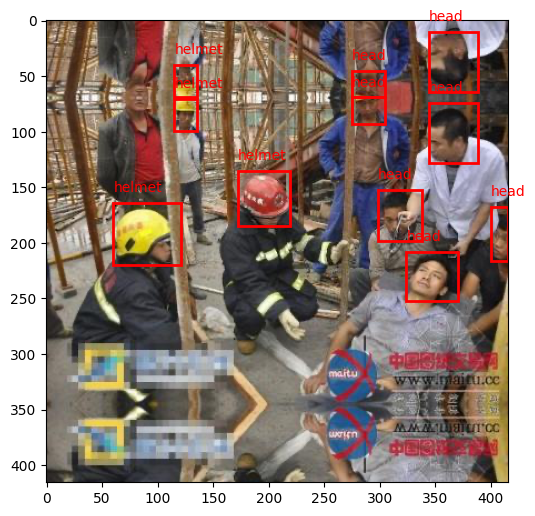

Number of augmented images: 8000
Number of augmented annotations: 8000


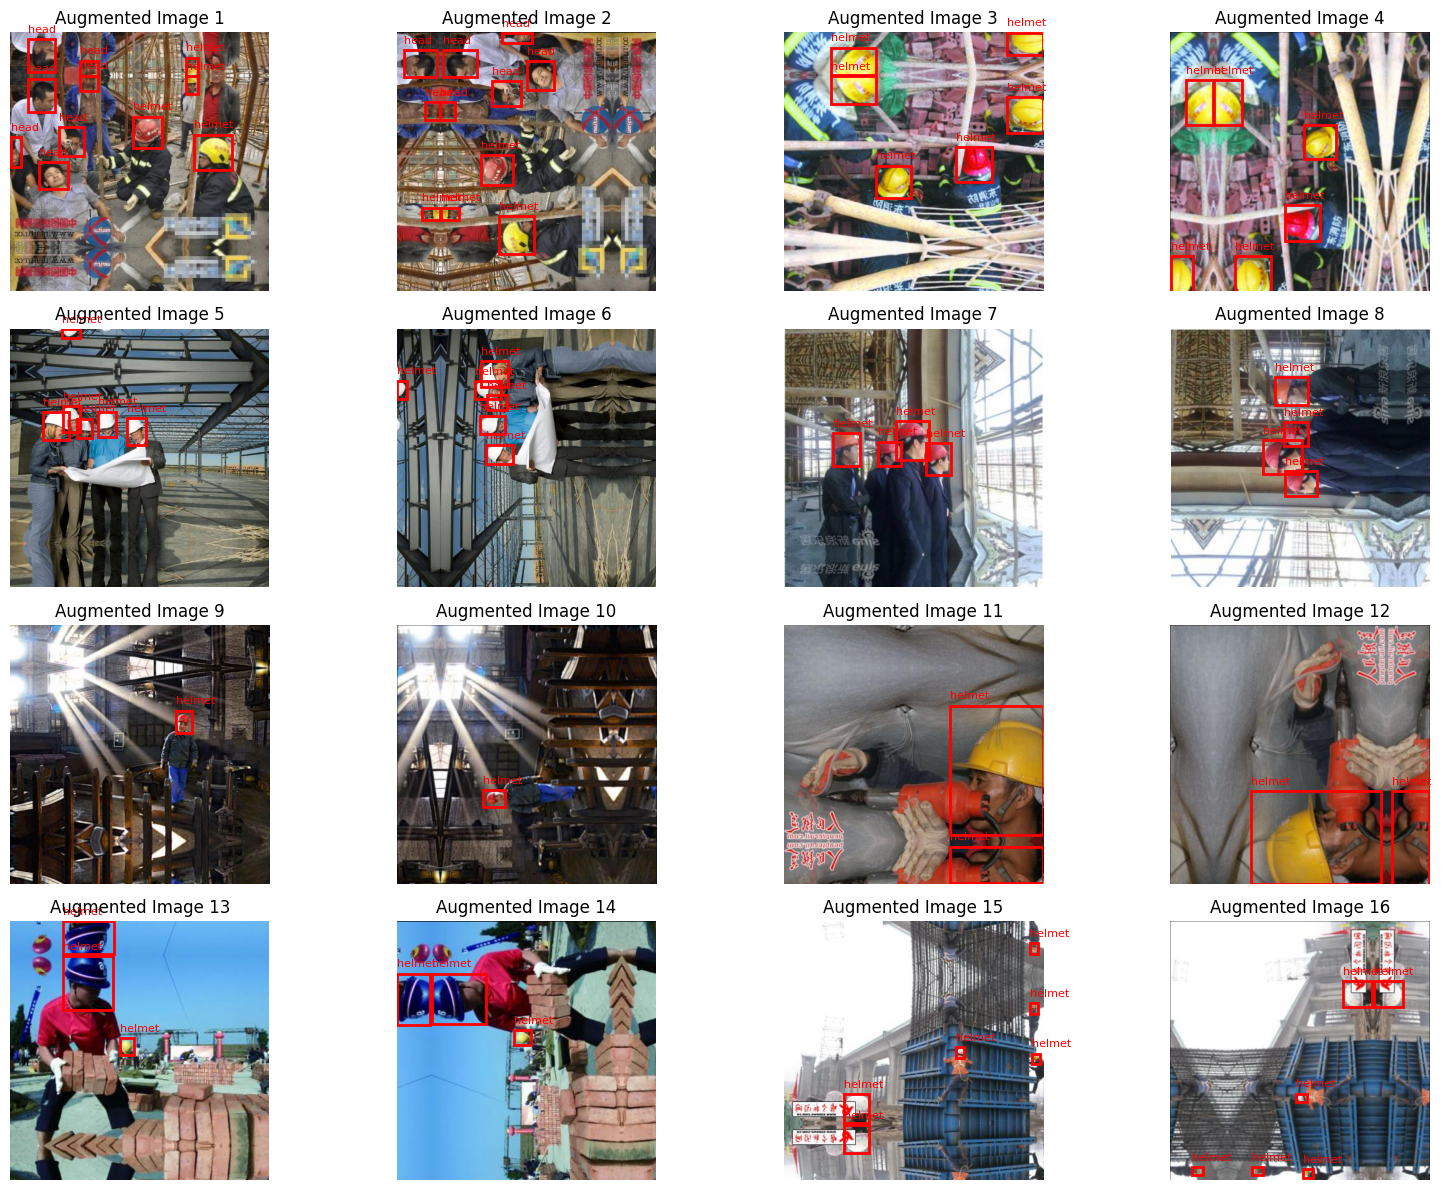

In [26]:
# Print the number of images in the train and test sets
print(f"Number of train images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

# Display the first train image and its annotations
first_train_image = train_images[0]
first_train_annotations = train_annotations[0]

# Visualize the bounding boxes on the first train image
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(first_train_image)

for xmin, ymin, xmax, ymax, label in first_train_annotations:
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='r', linewidth=2))
    plt.text(xmin, ymin - 10, label, color='r', fontsize=10)

plt.show()

# Print the number of augmented images and annotations
print(f"Number of augmented images: {len(augmented_train_images)}")
print(f"Number of augmented annotations: {len(augmented_train_annotations)}")

# Display a grid of augmented images
fig, axs = plt.subplots(4, 4, figsize=(16, 12))
axs = axs.ravel()

for i, (ax, image, annotation) in enumerate(zip(axs, augmented_train_images, augmented_train_annotations)):
    ax.imshow(image)
    for xmin, ymin, xmax, ymax, label in annotation:
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='r', linewidth=2))
        ax.text(xmin, ymin - 10, label, color='r', fontsize=8)
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()